In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content/drive/MyDrive/Dataset4

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# --- Config ---
data_dir = '/content/drive/MyDrive/Dataset4'
img_height = 227
img_width = 227
batch_size = 16
seed = 50
val_split = 0.2
test_split = 0.1
combined_split = val_split + test_split

# Step 1.1: Load training + val+test pool (70%)
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=combined_split,  # Reserve 30% of data
    subset='training',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Step 1.2: Load val+test (30%) for further splitting
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=combined_split,
    subset='validation',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Step 2: From the 30%, take 2/3 for validation (20%), 1/3 for test (10%)
val_batches = int((val_split / combined_split) * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

# --- Step 3: Class names ---
class_names = train_val_ds.class_names
num_classes = len(class_names)

train_ds = train_val_ds
val_ds = val_ds
test_ds = test_ds

# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 450 files belonging to 3 classes.
Using 315 files for training.
Found 450 files belonging to 3 classes.
Using 135 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
from tensorflow.keras import layers, models

def build_alexnet(input_shape, num_classes):
    model = models.Sequential(name='AlexNet')
    model.add(tf.keras.Input(shape=input_shape))
    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(96, (11, 11), strides=4, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(layers.Conv2D(256, (5, 5), padding="same", activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(layers.Conv2D(384, (3, 3), padding="same", activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), padding="same", activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


In [ ]:
num_classes = len(class_names)

model = build_alexnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,293,635 (222.37 MB)

 Trainable params: 58,293,635 (222.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import time

start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.3383 - loss: 1.1158 - val_accuracy: 0.3125 - val_loss: 1.1116
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.3225 - loss: 1.1011 - val_accuracy: 0.3542 - val_loss: 1.0862
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.3758 - loss: 1.0698 - val_accuracy: 0.6771 - val_loss: 0.9444
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.6510 - loss: 0.7708 - val_accuracy: 0.8750 - val_loss: 0.4985
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.7691 - loss: 0.4956 - val_accuracy: 0.6875 - val_loss: 0.3937
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8085 - loss: 0.3981 - val_accuracy: 0.9688 - val_loss: 0.1422
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.9418 - loss: 0.1494 - val_accuracy: 0.9479 - val_loss: 0.1292
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9879 - loss: 0.0454 - val_accuracy: 0.9896 - val_loss:

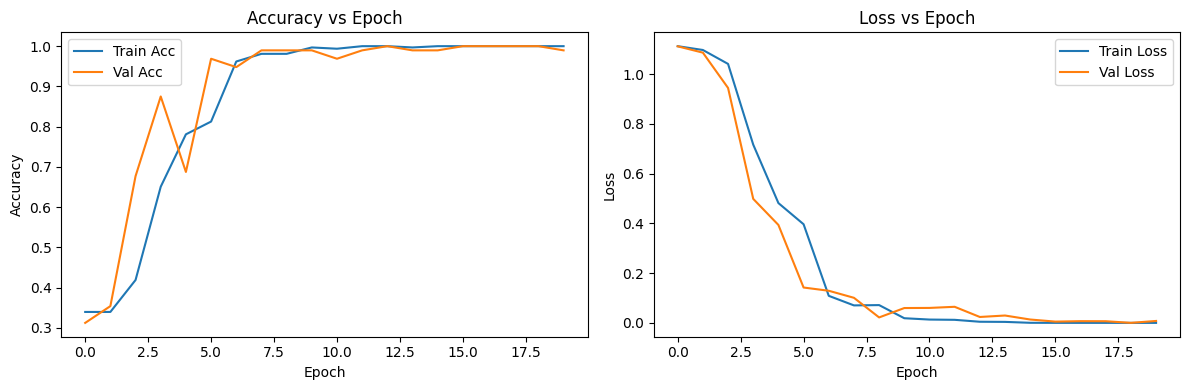

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

print(f"Accuracy Score = {np.max(history.history['val_accuracy']) * 100:.2f}%")




Accuracy Score = 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


<Figure size 800x800 with 0 Axes>

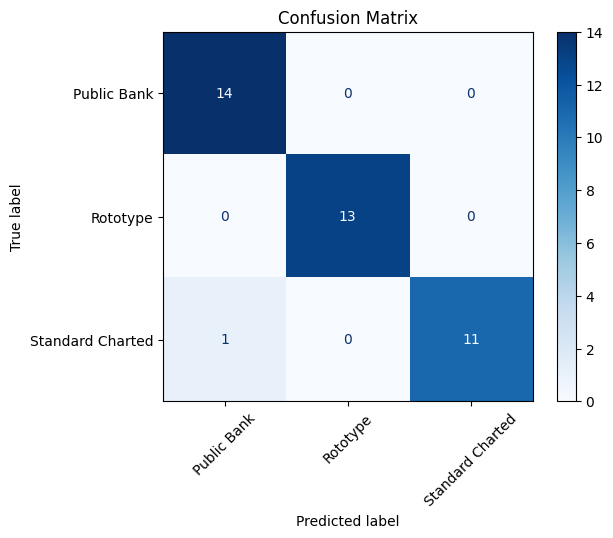

              Class  Accuracy (%)  Precision (%)  Recall (%)  Specificity (%)  \
0       Public Bank         97.44          93.33      100.00             96.0   
1          Rototype         97.44         100.00      100.00            100.0   
2  Standard Charted         97.44         100.00       91.67            100.0   

   F1-Score (%)  
0         96.55  
1        100.00  
2         95.65  


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1).numpy()
    y_pred.extend(pred_labels)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Specificity calculation
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Other metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Tabular format
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy (%)': [accuracy * 100] * len(class_names),
    'Precision (%)': precision * 100,
    'Recall (%)': recall * 100,
    'Specificity (%)': np.array(specificities) * 100,
    'F1-Score (%)': f1 * 100
})

metrics_df = metrics_df.round(2)
print(metrics_df)



In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 1.0000 - loss: 1.4515e-05
Test Accuracy: 100.00%
Test Loss: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


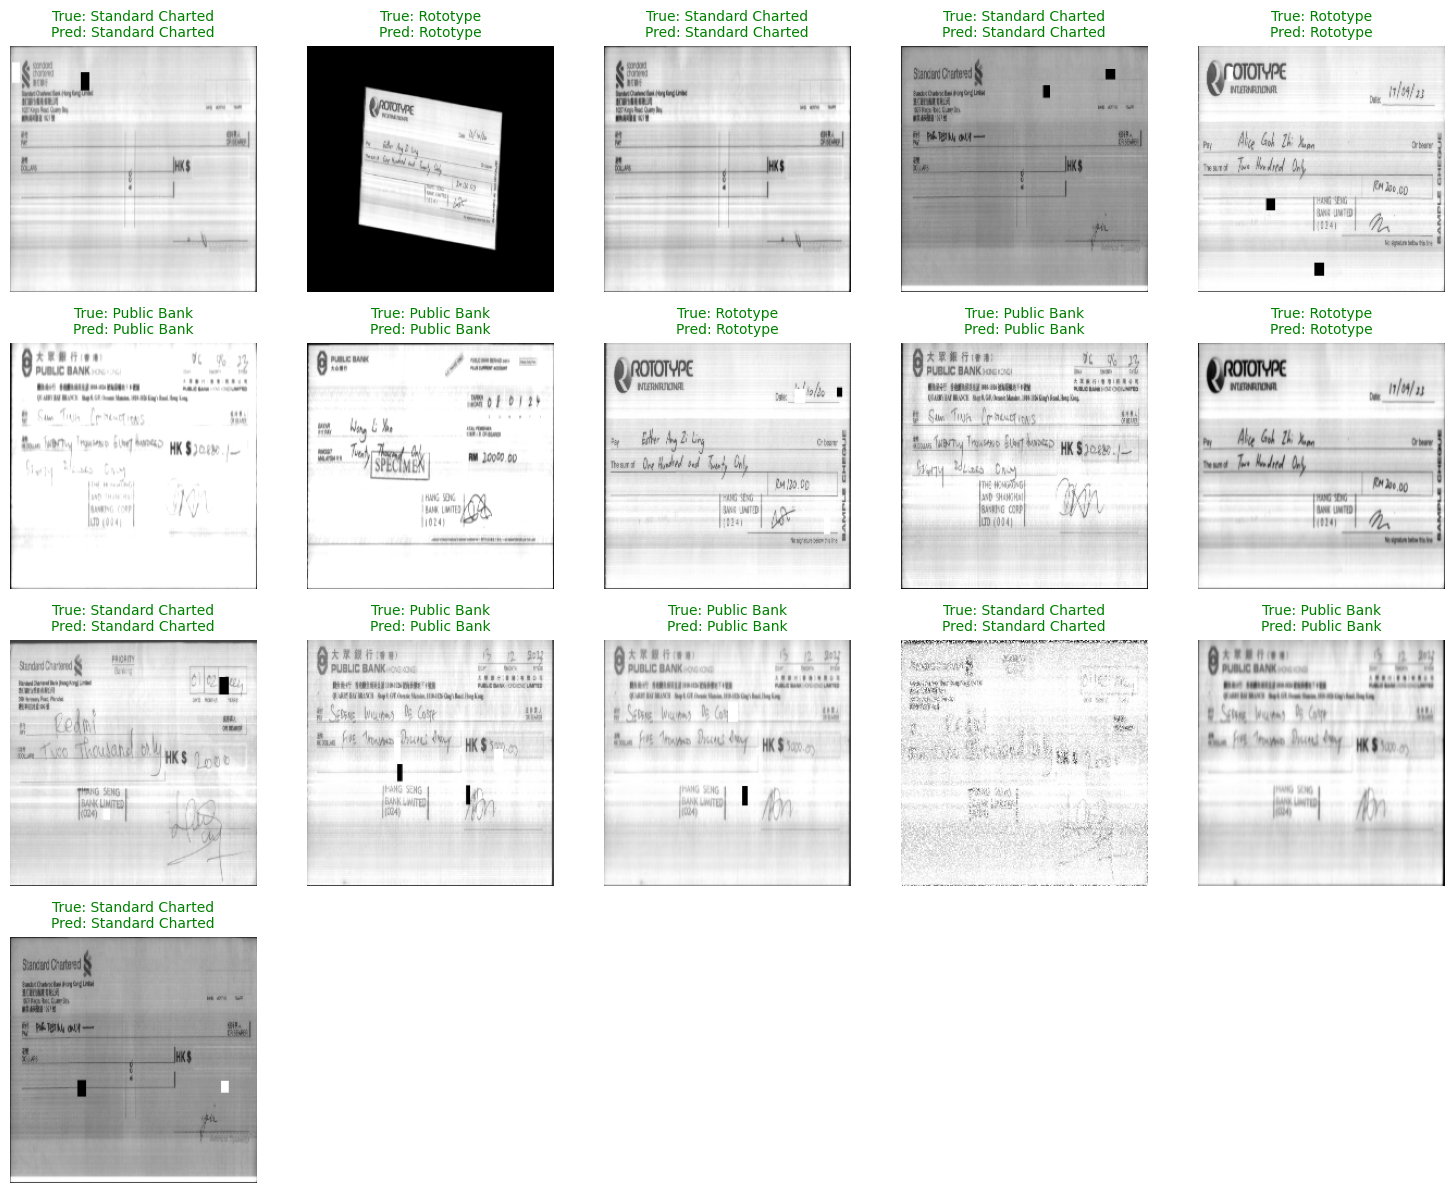

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get one batch from test dataset
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1).numpy()

    num_to_display = min(25, len(images))

    plt.figure(figsize=(15, 15))
    for i in range(num_to_display):
        ax = plt.subplot(5, 5, i + 1)

        # Normalize image to [0,1] for display
        img = images[i].numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        plt.imshow(img)
        true_class = class_names[labels[i].numpy()]
        pred_class = class_names[pred_labels[i]]

        # Color the title: green if correct, red if incorrect
        color = "green" if true_class == pred_class else "red"
        plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10, color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)
model.save('/content/drive/MyDrive/Models/model13.keras')
